# Custom version of Stable Diffusion

In [1]:
!pip install transformers diffusers ftfy accelerate


[notice] A new release of pip available: 22.1.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [2]:
from pathlib import Path
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [3]:
import torch
from torchvision import transforms
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import math

In [4]:
from transformers import CLIPTextModel, CLIPTokenizer

In [5]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.6.self_attn.v_proj.bias', 'vision_model.encoder.layers.11.mlp.fc2.bias', 'vision_model.encoder.layers.20.layer_norm2.weight', 'vision_model.encoder.layers.5.self_attn.q_proj.weight', 'vision_model.encoder.layers.10.self_attn.k_proj.weight', 'vision_model.encoder.layers.13.self_attn.v_proj.bias', 'vision_model.encoder.layers.8.self_attn.q_proj.bias', 'vision_model.encoder.layers.11.self_attn.out_proj.weight', 'vision_model.encoder.layers.6.mlp.fc2.weight', 'vision_model.encoder.layers.15.mlp.fc1.bias', 'vision_model.encoder.layers.17.self_attn.out_proj.bias', 'vision_model.encoder.layers.19.self_attn.q_proj.weight', 'vision_model.encoder.layers.20.layer_norm2.bias', 'vision_model.encoder.layers.14.mlp.fc2.weight', 'vision_model.encoder.layers.3.self_attn.out_proj.bias', 'vision_model.encoder.layers.9.mlp.fc1.weight', 'vision_model.encoder.lay

In [6]:
from diffusers import AutoencoderKL, UNet2DConditionModel

# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [7]:
from diffusers import LMSDiscreteScheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

## Methods

In [8]:
def make_text_embs(promt, negative_prompt=""): 
    token_info = tokenizer([prompt], padding="max_length", truncation=True, return_tensors="pt")
    token_embs = text_encoder(token_info.input_ids.to("cuda"))[0];
    
     # make text_embs
    uncond_info = tokenizer([negative_prompt], padding="max_length", truncation=True, return_tensors="pt")
    uncond_embs = text_encoder(uncond_info.input_ids.to("cuda"))[0]
    text_embs = torch.cat([uncond_embs, token_embs])
    return text_embs

In [9]:
def gen_image(text_embs, height=512, width=512, steps=50, gd=7.5, seed=100, get_all=False, return_preview=False, latents=None, start_step=0):
    torch.manual_seed(seed)
    
    if latents == None or start_step == 0:
        latents = torch.randn(len(text_embs)//2, unet.in_channels, height // 8, width // 8).to("cuda").half()
        latents = latents * scheduler.init_noise_sigma
    else:
        t = scheduler.timesteps[start_step-2]
        input = torch.cat([latents] * 2)
        input = scheduler.scale_model_input(input, t)

        # predict the noise residual
        with torch.no_grad():
            pred = unet(input, t, encoder_hidden_states=text_embs).sample

        # perform guidance
        pred_uncond, pred_text = pred.chunk(2)
        pred = pred_uncond + gd * (pred_text - pred_uncond)

        # compute the "previous" noisy sample
        latents = scheduler.step(pred, t, latents).prev_sample

    scheduler.set_timesteps(steps)
    latents_list = []
    
    for i, t in enumerate(tqdm(scheduler.timesteps)):
        if start_step > i:
            continue
            
        input = torch.cat([latents] * 2)
        input = scheduler.scale_model_input(input, t)

        # predict the noise residual
        with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=text_embs).sample

        # perform guidance
        pred_uncond, pred_text = pred.chunk(2)
        pred = pred_uncond + gd * (pred_text - pred_uncond)

        # compute the "previous" noisy sample
        updated_info = scheduler.step(pred, t, latents)
        latents = updated_info.prev_sample
        
        if get_all:
            latents_list.append(updated_info.pred_original_sample if return_preview else latents)
    
    if get_all:
        return latents_list
    
    return latents

In [10]:
def decode_latents(latents, scale_factor=1.0):
    with torch.no_grad():
        im_data = vae.decode(latents * 1 / 0.18215).sample[0]
        
    norm_im_data = (im_data * 0.5 + 0.5).clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy()
    rgb_im_data = (norm_im_data * 255).round().astype("uint8")
    im = Image.fromarray(rgb_im_data)
    
    return im.resize(((int)(im.width * scale_factor), (int)(im.height * scale_factor)))

In [11]:
def show_latents_grid(latents_list, cols=8, scale_factor=1.0):
    images = [decode_latents(item, scale_factor) for item in latents_list]
    
    w,h = images[0].size
    rows = math.ceil(len(images) / cols)
    grid = Image.new('RGB', size=(cols*w, rows*h))
    
    for i, img in enumerate(images): 
        grid.paste(img, box=(i%cols*w, i//cols*h))
        
    return grid

In [12]:
def load_image(img_path, size=(512, 512), to_tensor=False):
    im = Image.open(img_path).convert("RGB").resize(size)
    
    if to_tensor:
        return transforms.ToTensor()(im)
    
    return im

In [13]:
def encode_latents(img, scale_factor=1.0):
    tensor_img = transforms.ToTensor()(img).half()
    tensor_img = (tensor_img * 2.0) - 1.0
    
    with torch.no_grad():
        encoded = vae.encode(tensor_img.unsqueeze(0).to(vae.device))
        latents = 0.18215 * encoded.latent_dist.sample()
        
        return latents

In [14]:
def image_to_noise(img, total_steps, noise_step, seed=100):
    latents = encode_latents(img)
    torch.manual_seed(seed)
    noise = torch.randn_like(latents)
    scheduler.set_timesteps(total_steps)
    latents = scheduler.add_noise(latents, noise, timesteps=torch.tensor([scheduler.timesteps[noise_step]]))
    
    return latents

### Usage

  0%|          | 0/50 [00:00<?, ?it/s]

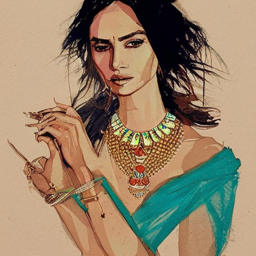

In [15]:
## Simple Negative Prompt
prompt = "a indian model portrait with some jewellery by conrad roset, greg rutkowski"
latents = gen_image(make_text_embs(prompt), seed=390)
decode_latents(latents, scale_factor=0.5)

/opt/conda/lib/python3.8/site-packages/diffusers/schedulers/scheduling_lms_discrete.py:155: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrated_coeff = integrate.quad(lms_derivative, self.sigmas[t], self.sigmas[t + 1], epsrel=1e-4)[0]


  0%|          | 0/50 [00:00<?, ?it/s]

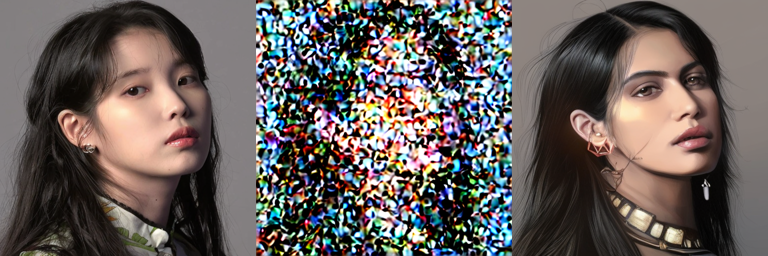

In [16]:
## Image to Image Workflow
init_image = load_image("./images/iu.png")
influece_ratio = 0.5
prompt = "a indian model portrait with some jewellery by conrad roset, greg rutkowski"
total_steps = 50
seed = 390

noise_step = math.floor(total_steps * influece_ratio)
init_latents = image_to_noise(init_image, total_steps=total_steps, noise_step=noise_step-1, seed=seed)
latents = gen_image(make_text_embs(prompt), steps=total_steps, latents=init_latents, start_step=noise_step+1, seed=seed)
show_latents_grid([encode_latents(init_image), init_latents, latents], cols=3, scale_factor=0.5)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

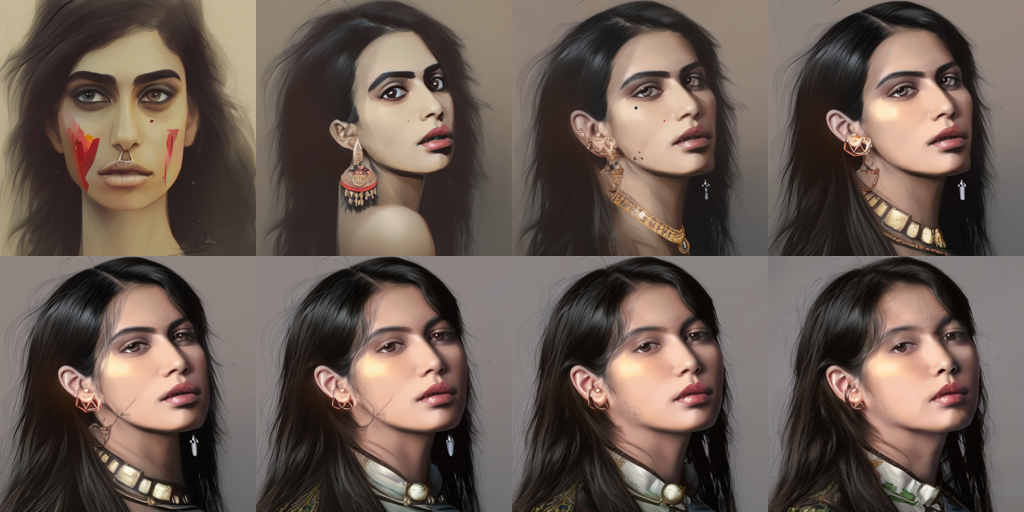

In [17]:
# influence grid

latents_list = []

init_image = load_image("./images/iu.png")
prompt = "a indian model portrait with some jewellery by conrad roset, greg rutkowski"
total_steps = 50
seed = 390

for influece_ratio in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    noise_step = math.floor(total_steps * influece_ratio)
    init_latents = image_to_noise(init_image, total_steps=total_steps, noise_step=noise_step-1, seed=seed)
    latents = gen_image(make_text_embs(prompt), steps=total_steps, latents=init_latents, start_step=noise_step+1, seed=seed)
    latents_list.append(latents)
    
show_latents_grid(latents_list, cols=4, scale_factor=0.5)

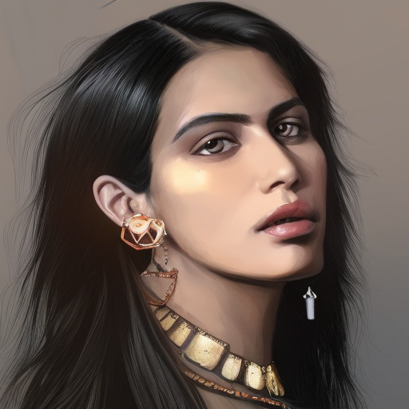

In [18]:
# We can pick an image we like
decode_latents(latents_list[3], scale_factor=0.8)